In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib

while pathlib.Path(".").absolute().name != "aerial-disentangled-representations":
    os.chdir("..")

In [8]:
os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
from disentangled_representations.src.data_processing.aerial_dataset_loaders import create_train_data_loader_for_image_pairs

train_data_loader = create_train_data_loader_for_image_pairs(batch_size=8, num_workers=4)

2025-04-24 22:21:35.826 | INFO     | disentangled_representations.src.data_processing.aerial_dataset_loaders:create_train_data_loader_for_image_pairs:13 - ({ds.__class__.__name__: len(ds) for ds in train_datasets})={'LEVIR_CDPlus_Dataset': 637, 'SYSU_CD_Dataset': 12000, 'S2LookingDataset': 3500, 'Hi_UCD_Dataset': 12000, 'GVLM_CD_Dataset': 17, 'BANDONDataset': 534}
2025-04-24 22:21:35.830 | INFO     | disentangled_representations.src.data_processing.aerial_dataset_loaders:create_train_data_loader_for_image_pairs:22 - num_samples=10384 per epoch.


In [4]:
train_data_loader_iterator = iter(train_data_loader)

In [5]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


def visualize_batch_pairs(batch, n=4):
    imgs_A, imgs_B = batch
    imgs_A, imgs_B = imgs_A[:n], imgs_B[:n]

    grid_A = vutils.make_grid(imgs_A, nrow=n, padding=4)
    grid_B = vutils.make_grid(imgs_B, nrow=n, padding=4)

    np_A = grid_A.permute(1, 2, 0).cpu().numpy()
    np_B = grid_B.permute(1, 2, 0).cpu().numpy()

    fig, axes = plt.subplots(2, 1, figsize=(n * 2, 4))
    axes[0].imshow(np_A)
    axes[0].set_title("View A")
    axes[1].imshow(np_B)
    axes[1].set_title("View B")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


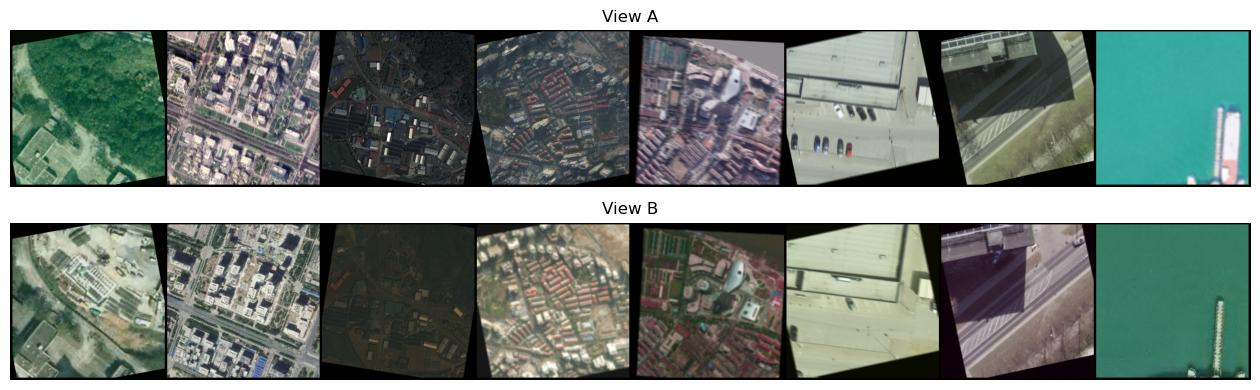

In [7]:
batch_example = next(train_data_loader_iterator)
visualize_batch_pairs(batch_example, 8)